In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, DateType
from pyspark.sql.functions import col,array_contains,udf,desc
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt
import numpy as np

In [2]:
spark = SparkSession.builder.appName('IPL Pre-Match Analysis').getOrCreate()

In [3]:
ipl_teams = ["Chennai Super Kings","Delhi Capitals","Kolkata Knight Riders","Mumbai Indians","Kings XI Punjab","Rajasthan Royals","Royal Challengers Bangalore","Sunrisers Hyderabad"]

cities = ['Bangalore', 'Kochi', 'Chennai', 'Centurion', 'Ranchi', 'Mumbai', 'Ahmedabad', 'Durban', 'Kolkata', 'Cape Town', 'Dharamsala', 'Sharjah', 'Johannesburg', 'Kimberley', 'Pune', 'Delhi', 'Raipur', 'Chandigarh', 'Nagpur', 'Abu Dhabi', 'Bloemfontein', 'Kanpur', 'Hyderabad', 'Rajkot', 'Port Elizabeth', 'Dubai', 'Indore', 'Cuttack', 'East London', 'Jaipur', 'Visakhapatnam']

teams_squad = {
    
    "Chennai Super Kings" : ["MS Dhoni","BH Varma","Imran Tahir","HA Reddy","RD Gaikwad","MM Ali","HA Nishaanth","RA Jadeja","DL Chahar","N Jagadeesan","SK Raina","KM Asif","SN Thakur","RS Kishore","F du Plessis","DJ Bravo","CA Pujara","Karn Sharma","L Ngidi","AT Rayudu","JP Behrendorff","MJ Santner","K Gowtham","SM Curran","RV Uthappa"],
    "Delhi Capitals" : ["RR Pant","K Rabada","MP Stoinis","SW Billings","AM Rahane","CR Woakes","R Ashwin","SPD Smith","M Siddharth","S Mulani","Vishnu Vinod","A Joshi","Lalit Yadav","Avesh Khan","AR Patel","SS Iyer","A Mishra","I Sharma","Ripal Patel","S Dhawan","SO Hetmyer","P Dubey","PP Shaw","A Nortje","UT Yadav","L Meriwala","TK Curran"],
    "Kolkata Knight Riders": ["EJG Morgan","Shivam Mavi","S Sandeep Warrier", "Kuldeep Yadav","Shakib Al Hasan","SP Narine","Vaibhav Arora","LH Ferguson","BCJ Cutting","Tim Seifert","KK Nair","SP Jackson","V Iyer","KD Karthik","Harbhajan Singh","PJ Cummins","AD Russell","M Prasidh Krishna","Shubman Gill","N Rana","P Negi","KL Nagarkoti","Varun Chakaravarthy","Gurkeerat Singh" ,"RA Tripathi"],
    "Mumbai Indians":["RG Sharma","AP Tare","AS Roy","Anmolpreet Singh","CA Lynn","DS Kulkarni","KH Pandya","HH Pandya","Ishan Kishan","JJ Bumrah","KA Pollard","J Yadav","Mohsin Khan","Yudhvir Charak","Q de Kock","RD Chahar","SS Tiwary","SA Yadav","TA Boult","AF Milne","NM Coulter-Nile","PP Chawla","JDS Neesham","Marco Jansen","Arjun Tendulkar"],
    "Kings XI Punjab":["KL Rahul","Harpreet Brar","Ishan Porel","Utkarsh Singh","MC Henriques","Jhye Richardson","Mandeep Singh","CJ Jordan","DJ Hooda","R Bishnoi","Arshdeep Singh","Riley Meredith","SN Khan","MA Agarwal","Mohammed Shami","Darshan Nalkande","Shahrukh Khan","N Pooran","Fabian Allen","CH Gayle","M Ashwin","Jalaj Saxena","Dawid Malan","Saurabh Kumar","P Simran Singh"],
    "Rajasthan Royals": ["SV Samson","Kuldip Yadav","BA Stokes","CH Morris","AJ Tye","Kartik Tyagi","S Gopal","R Tewatia","JD Unadkat","M Markande","Gerald Coetzee","MK Lomror","R Parag","YBK Jaiswal","Anuj Rawat","A Singh","JC Archer","Chetan Sakariya","S Dube","KC Cariappa","Mustafizur Rahman","DA Miller","LS Livingstone","JC Buttler","M Vohra"],
    "Royal Challengers Bangalore" : ["V Kohli","Mohammed Siraj","SC Kuggeleijn","AB de Villiers","DR Sams","Shahbaz Ahmed","Finn Allen","KS Bharat","YS Chahal","NA Saini","K Jamieson","DT Christian","D Padikkal","GJ Maxwell","S Prabhudessai","Sachin Baby","P Deshpande","Washington Sundar","H Patel","A Zampa","KW Richardson","R Patidar","M Azharuddeen"],
    "Sunrisers Hyderabad": ["KS Williamson","Rashid Khan","WP Saha","KK Ahmed","Abdul Samad","Sandeep Sharma","Mujeeb Ur Rahman","SP Goswami","KM Jadhav","DA Warner","Mohammad Nabi","Abhishek Sharma","Basil Thampi","JJ Roy","JO Holder","B Kumar","J Suchith","Virat Singh","T Natarajan","S Nadeem","JM Bairstow","MK Pandey","V Shankar","S Kaul","PK Garg"],
    
    
}

## Adding Data

In [4]:
league_schema = StructType() \
      .add("id",IntegerType(),True) \
      .add("city",StringType(),True) \
      .add("date",StringType(),True) \
      .add("player_of_match",StringType(),True) \
      .add("venue",StringType(),True) \
      .add("neutral_venue",IntegerType(),True) \
      .add("team1",StringType(),True) \
      .add("team2",StringType(),True) \
      .add("toss_winner",StringType(),True) \
      .add("toss_decision",StringType(),True) \
      .add("winner",StringType(),True) \
      .add("result",StringType(),True) \
      .add("result_margin",IntegerType(),True) \
      .add("method",StringType(),True) \
      .add("umpire1",StringType(),True) \
      .add("umpire2",StringType(),True)
      
league_data = spark.read.format("csv") \
      .option("header", True) \
      .schema(league_schema) \
      .load("IPL Matches 2008-2020.csv")

In [5]:
match_schema = StructType() \
      .add("id",IntegerType(),True) \
      .add("inning",IntegerType(),True) \
      .add("over",IntegerType(),True) \
      .add("ball",IntegerType(),True) \
      .add("batsman",StringType(),True) \
      .add("non_striker",StringType(),True) \
      .add("bowler",StringType(),True) \
      .add("batsman_runs",IntegerType(),True) \
      .add("extra_runs",IntegerType(),True) \
      .add("total_runs",IntegerType(),True) \
      .add("non_boundary",IntegerType(),True) \
      .add("is_wicket",IntegerType(),True) \
      .add("dismissal_kind",StringType(),True) \
      .add("player_dismissed",StringType(),True) \
      .add("fielder",StringType(),True) \
      .add("extras_type",StringType(),True) \
      .add("batting_team",StringType(),True) \
      .add("bowling_team",StringType(),True)
      
match_data = spark.read.format("csv") \
      .option("header", True) \
      .schema(match_schema) \
      .load("IPL Ball-by-Ball 2008-2020.csv")

In [6]:
league_data.show(5)

+------+----------+----------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+------+-------+---------+
|    id|      city|      date|player_of_match|               venue|neutral_venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|method|umpire1|  umpire2|
+------+----------+----------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+------+-------+---------+
|335982| Bangalore|18-04-2008|    BB McCullum|M Chinnaswamy Sta...|            0|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knight Ri...|   runs|          140|     N|     NA|Asad Rauf|
|335983|Chandigarh|19-04-2008|     MEK Hussey|Punjab Cricket As...|            0|     Kings 

In [7]:
match_data.show(5)

+------+------+----+----+-----------+-----------+---------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------------+
|    id|inning|over|ball|    batsman|non_striker|   bowler|batsman_runs|extra_runs|total_runs|non_boundary|is_wicket|dismissal_kind|player_dismissed|fielder|extras_type|        batting_team|        bowling_team|
+------+------+----+----+-----------+-----------+---------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------------+
|335982|     1|   6|   5| RT Ponting|BB McCullum|AA Noffke|           1|         0|         1|           0|        0|            NA|              NA|     NA|         NA|Kolkata Knight Ri...|Royal Challengers...|
|335982|     1|   6|   6|BB McCullum| RT Ponting|AA Noffke|           1|         0|         1|           0|        0|            NA|              NA|   

## Team Vs Team Filtering

In [8]:
def head_to_head(t1,t2):
    
    teams = [t1,t2]
    h2h = league_data.filter(league_data.team1.isin(teams)).filter(league_data.team2.isin(teams))
    total_matches = h2h.count()
    h2h_wins = h2h.groupBy("winner").count()
    
    return h2h,total_matches,h2h_wins

In [9]:
def Key_Players(t1,t2,h2h):
    
    team1_squad = teams_squad[t1]
    team2_squad = teams_squad[t2]

    match_squad = team1_squad + team2_squad

    pom = h2h.filter(h2h.player_of_match.isin(match_squad))

    key_players = pom.groupby("player_of_match").agg(F.count('player_of_match').alias('points')).sort(desc("points"))
    
    return key_players

### Head to Head stats

## Venue Filtering

In [10]:
def Venue_Stats(city):
    
    venue = league_data.filter(league_data.city == city)
    ven_count = venue.count()
    
    return venue, ven_count

### Toss Winner Decision

In [11]:
def Toss_Winner_Stats(venue):
    
    toss_match_win_count = venue.filter(venue.toss_winner == venue.winner).count()
    tmw_decision = venue.filter(venue.toss_winner == venue.winner).groupBy("toss_decision").count()
    
    return toss_match_win_count, tmw_decision

### Match Winner Decision

In [12]:
def MatchWinnerDecision(winner,toss_winner,toss_decision):
    
    if(winner == toss_winner):
        return toss_decision
    else:
        if(toss_decision == "bat"):
            return "field"
        else:
            return "bat"
        
def Match_Win_Toss(venue):
    
    udf_MWD = udf(MatchWinnerDecision, StringType())
    venue_with_toss = venue.withColumn("winner_toss", udf_MWD("winner","toss_winner","toss_decision"))
    match_win_decision = venue_with_toss.groupBy("winner_toss").count()
    
    return match_win_decision

### Venue+Team Statistics

In [13]:
def TeamsAtVenue(venue,t):
    
    team_venue = venue.filter((venue.team1 == t) | (venue.team2 == t))
    team_total = team_venue.count()
    team_venue_win = team_venue.filter(col("winner") == t).count()
    team_pc = int((team_venue_win/team_total) * 100)
    
    return team_venue, team_total, team_venue_win, team_pc

In [14]:
def Teams_Venue_id(team_venue):
    
    team_ven_id = team_venue.select("id").collect()
    for i in range(0,len(team_ven_id)):
        team_ven_id[i] = team_ven_id[i].id
        
    return team_ven_id

In [15]:
def team_MatchStats(matches,team):
    
    venue_matches = match_data.filter(match_data.id.isin(matches))
    team_matches = venue_matches.filter(venue_matches.batting_team == team)
    inn_match = team_matches.groupBy("id").agg(F.sum('total_runs').alias('sum_runs'), F.count('id').alias('sum_balls'))
    
    inn_runs = inn_match.select("sum_runs").collect()
    for i in range(0,len(inn_runs)):
        inn_runs[i] = inn_runs[i].sum_runs
        
    inn_balls = inn_match.select("sum_balls").collect()
    for i in range(0,len(inn_balls)):
        inn_balls[i] = inn_balls[i].sum_balls
        
    return inn_runs,inn_balls

def calcRR_Team(runs,balls):
    
    if(balls < 120):
        overs = int(balls/6)
        return round(runs/overs,2)
    else:
        return round(runs/20,2)
    
def RR_Teams(team_ven_id,t):
    
    team_runs, team_balls = team_MatchStats(team_ven_id,t)
    
    team_rr = [0 for x in range(0,len(team_ven_id))]
    for i in range(0,len(team_ven_id)):    
        team_rr[i] = calcRR_Team(team_runs[i],team_balls[i])
        
    return team_rr

### Venue Run-Rate

In [16]:
def venue_id(venue):
    
    venueMatchesID = venue.select("id").collect()

    for i in range(0,len(venueMatchesID)):
        venueMatchesID[i] = venueMatchesID[i].id

    return venueMatchesID

In [17]:
def venue_MatchStats(matches):
    
    venue_matches = match_data.filter(match_data.id.isin(matches))
    inn_match = venue_matches.groupBy("id").agg(F.sum('total_runs').alias('sum_runs'), F.count('id').alias('sum_balls'))
    
    inn_runs = inn_match.select("sum_runs").collect()
    for i in range(0,len(inn_runs)):
        inn_runs[i] = inn_runs[i].sum_runs
        
    inn_balls = inn_match.select("sum_balls").collect()
    for i in range(0,len(inn_balls)):
        inn_balls[i] = inn_balls[i].sum_balls
        
    return inn_runs,inn_balls
    
    
def calcRR_Venue(runs,balls):
    
    if(balls < 240):
        overs = int(balls/6)
        return round(runs/overs,2)
    else:
        return round(runs/40,2)
    

def RR_Venue(venueMatches,venue_runs,venue_balls):

    run_rate = [0 for x in range(0,len(venueMatches))]

    for i in range(0,len(venueMatches)):

        run_rate[i] = calcRR_Venue(venue_runs[i],venue_balls[i])

    return run_rate

In [18]:
def top_players_venue(matches,team):
    
    venue_matches = match_data.filter(match_data.id.isin(matches))
    bat_team = venue_matches.filter(venue_matches.batting_team == team)
    bat_squad = bat_team.filter(bat_team.batsman.isin(teams_squad[team]))
    top_bat = bat_squad.groupBy("batsman").agg(F.sum('batsman_runs').alias('runs_scored')).sort(desc("runs_scored"))
    
    bowl_team = venue_matches.filter(venue_matches.bowling_team == team)
    bowl_squad = bowl_team.filter(bowl_team.bowler.isin(teams_squad[team]))
    wickets = bowl_squad.filter(bowl_squad.is_wicket == 1)
    bowler_wickets = wickets.filter(wickets.dismissal_kind != "run out")
    top_bowl = bowler_wickets.groupby("bowler").agg(F.count('is_wicket').alias("wickets")).sort(desc("wickets"))
    
    return top_bat, top_bowl

# Analysis Tool

Welcome to IPL Pre-Match Analysis Tool

Given below are the teams competing in IPL 2021. Please select the 2 distinct teams competing in your desired match.

1. Chennai Super Kings
2. Delhi Capitals
3. Kolkata Knight Riders
4. Mumbai Indians
5. Kings XI Punjab
6. Rajasthan Royals
7. Royal Challengers Bangalore
8. Sunrisers Hyderabad

Enter First Team (1-8):- 1
Enter Second Team (1-8):- 4

The match you've selected is Chennai Super Kings Vs Mumbai Indians

Given below are some cities. Please select the city in which the match is being held.

1. Bangalore
2. Kochi
3. Chennai
4. Centurion
5. Ranchi
6. Mumbai
7. Ahmedabad
8. Durban
9. Kolkata
10. Cape Town
11. Dharamsala
12. Sharjah
13. Johannesburg
14. Kimberley
15. Pune
16. Delhi
17. Raipur
18. Chandigarh
19. Nagpur
20. Abu Dhabi
21. Bloemfontein
22. Kanpur
23. Hyderabad
24. Rajkot
25. Port Elizabeth
26. Dubai
27. Indore
28. Cuttack
29. East London
30. Jaipur
31. Visakhapatnam

Enter the city of the match (1-31):- 9

The venue for the ma

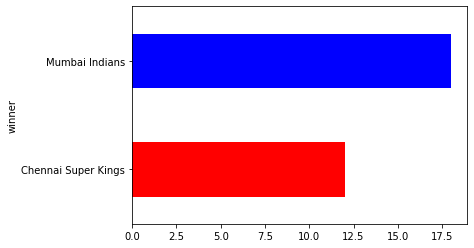

+-------------------+-----+
|winner             |count|
+-------------------+-----+
|Chennai Super Kings|12   |
|Mumbai Indians     |18   |
+-------------------+-----+


Please select the information you desire:

A. Chennai Super Kings Vs Mumbai Indians Statistics
B. Key Players in Chennai Super Kings Vs Mumbai Indians
C. Toss Win Analysis at Kolkata
D. Match Win Toss Analysis at Kolkata
E. Run-Rate at Kolkata
F. Key Players at Kolkata
G. Chennai Super Kings Statistics at Kolkata
H. Mumbai Indians Statistics at Kolkata
I. Chennai Super Kings Run-Rate at Kolkata
J. Mumbai Indians Run-Rate at Kolkata

Please Select Option(A-J) or type Q to exit: b


The key players for the following match are:- 
+---------------+------+
|player_of_match|points|
+---------------+------+
|      RG Sharma|     3|
|       SK Raina|     3|
|     KA Pollard|     3|
|      HH Pandya|     2|
|       DJ Bravo|     1|
+---------------+------+
only showing top 5 rows


Please select the information you desire:

A. 

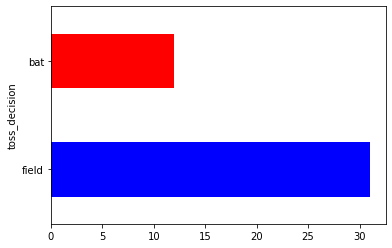

+-------------+-----+
|toss_decision|count|
+-------------+-----+
|field        |31   |
|bat          |12   |
+-------------+-----+


Please select the information you desire:

A. Chennai Super Kings Vs Mumbai Indians Statistics
B. Key Players in Chennai Super Kings Vs Mumbai Indians
C. Toss Win Analysis at Kolkata
D. Match Win Toss Analysis at Kolkata
E. Run-Rate at Kolkata
F. Key Players at Kolkata
G. Chennai Super Kings Statistics at Kolkata
H. Mumbai Indians Statistics at Kolkata
I. Chennai Super Kings Run-Rate at Kolkata
J. Mumbai Indians Run-Rate at Kolkata

Please Select Option(A-J) or type Q to exit: D


Total IPL Matches played at Kolkata:- 77

Below are the figures for the toss decision of the match winner:- 


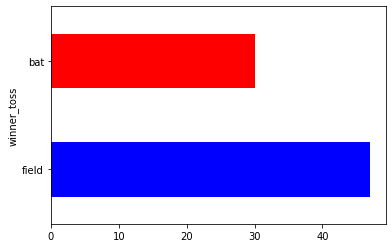

+-----------+-----+
|winner_toss|count|
+-----------+-----+
|field      |47   |
|bat        |30   |
+-----------+-----+


Please select the information you desire:

A. Chennai Super Kings Vs Mumbai Indians Statistics
B. Key Players in Chennai Super Kings Vs Mumbai Indians
C. Toss Win Analysis at Kolkata
D. Match Win Toss Analysis at Kolkata
E. Run-Rate at Kolkata
F. Key Players at Kolkata
G. Chennai Super Kings Statistics at Kolkata
H. Mumbai Indians Statistics at Kolkata
I. Chennai Super Kings Run-Rate at Kolkata
J. Mumbai Indians Run-Rate at Kolkata

Please Select Option(A-J) or type Q to exit: E


The Average Run-Rate at Kolkata is:- 8.04

Below is the per-match run-rate analysis:


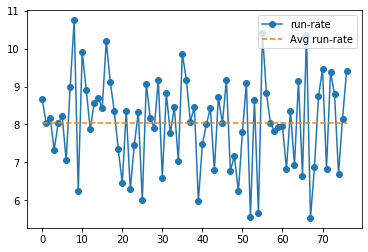


Please select the information you desire:

A. Chennai Super Kings Vs Mumbai Indians Statistics
B. Key Players in Chennai Super Kings Vs Mumbai Indians
C. Toss Win Analysis at Kolkata
D. Match Win Toss Analysis at Kolkata
E. Run-Rate at Kolkata
F. Key Players at Kolkata
G. Chennai Super Kings Statistics at Kolkata
H. Mumbai Indians Statistics at Kolkata
I. Chennai Super Kings Run-Rate at Kolkata
J. Mumbai Indians Run-Rate at Kolkata

Please Select Option(A-J) or type Q to exit: F


Chennai Super Kings Top Run-Scorers at Kolkata:- 
+--------+-----------+
| batsman|runs_scored|
+--------+-----------+
|MS Dhoni|        265|
|SK Raina|        227|
+--------+-----------+
only showing top 2 rows

Chennai Super Kings Top Wicket-Takers at Kolkata:- 
+---------+-------+
|   bowler|wickets|
+---------+-------+
| DJ Bravo|      7|
|RA Jadeja|      6|
+---------+-------+
only showing top 2 rows

Mumbai Indians Top Run-Scorers at Kolkata:- 
+----------+-----------+
|   batsman|runs_scored|
+-------

In [21]:
print("Welcome to IPL Pre-Match Analysis Tool\n")

print("Given below are the teams competing in IPL 2021. Please select the 2 distinct teams competing in your desired match.\n")

for i in range(0,len(ipl_teams)):
    print(str(i+1)+". "+ipl_teams[i])
    

con1 = False
while(con1 == False):
    
    t1 = int(input("\nEnter First Team (1-8):- "))
    
    t2 = int(input("Enter Second Team (1-8):- "))
    
    if(t1<1 or t1>8 or t2<1 or t2>8):
        print("Invalid Choice. Please enter again.")
        con1 = False
    elif(t1 != t2):
        con1 = True
    else:
        con1 = False
        print("Both teams cannot be same. Please select again.")
        
team1 = ipl_teams[t1-1]
team2 = ipl_teams[t2-1]
        
print("\nThe match you've selected is "+team1+" Vs "+team2)

print("\nGiven below are some cities. Please select the city in which the match is being held.\n")

for i in range(0,len(cities)):
    print(str(i+1)+". "+cities[i])
    
con2 = True
while(con2):
    
    c_inp = int(input("\nEnter the city of the match (1-31):- "))
    
    if(1 <= c_inp <= 31):
        con2 = False
    else:
        print("Invalid Choice. Please enter again.")
        
city = cities[c_inp-1]

print("\nThe venue for the match is "+city)

print("\n\nMatch:- "+team1+" VS "+team2)
print("Venue:- "+city)

menu = ""

venue, ven_count = Venue_Stats(city)
venueMatchesID = venue_id(venue)

while(menu != "Q"):
    
    print("\nPlease select the information you desire:")

    print("\nA. "+team1+" Vs "+team2+" Statistics")
    print("B. Key Players in "+team1+" Vs "+team2)
    print("C. Toss Win Analysis at "+city)
    print("D. Match Win Toss Analysis at "+city)
    print("E. Run-Rate at "+city)
    print("F. Key Players at "+city)
    print("G. "+team1+" Statistics at "+city)
    print("H. "+team2+" Statistics at "+city)
    print("I. "+team1+" Run-Rate at "+city)
    print("J. "+team2+" Run-Rate at "+city)
    
    menu = input("\nPlease Select Option(A-J) or type Q to exit: ")
    
    print("\n")
    
    if(menu == "a" or menu == "A"):
        
        h2h,total_matches,h2h_wins = head_to_head(team1,team2)
        
        print(team1+" and "+team2+" have played against each other "+str(total_matches)+" times.\n")
        
        print("The win ratio between the two teams is:- ")
        
        h2hw_pandas = h2h_wins.toPandas()
        
        h2hw_pandas.plot(x ='winner', y='count', color=['red', 'blue'], kind = 'barh',legend=False)
        plt.xticks(rotation=0)
        
        plt.show()
        
        h2h_wins.show(truncate=False)
        
    elif(menu == "b" or menu =="B"):
        
        h2h,total_matches,h2h_wins = head_to_head(team1,team2)
        
        key_players = Key_Players(team1,team2,h2h)
        
        print("The key players for the following match are:- ")
        
        key_players.show(5)
        
    elif(menu == "c" or menu == "C"):
        
        toss_match_win_count, tmw_decision = Toss_Winner_Stats(venue)
        
        print("Total IPL Matches played at "+city+":- "+str(ven_count))
        
        print("\nToss winner has been the Match Winner "+str(toss_match_win_count)+" times")
        print("Below are the toss decisions for the above stated figures:- ")
        
        tmwd_pandas = tmw_decision.toPandas()
        
        tmwd_pandas.plot(x ='toss_decision', y='count', color=['blue', 'red'], kind = 'barh',legend=False)
        plt.xticks(rotation=0)
        
        plt.show()
        
        tmw_decision.show(truncate=False)
        
    elif(menu == "d" or menu == "D"):
        
        
        match_win_decision = Match_Win_Toss(venue)
        
        print("Total IPL Matches played at "+city+":- "+str(ven_count))
        
        print("\nBelow are the figures for the toss decision of the match winner:- ")
        
        mwd_pandas = match_win_decision.toPandas()
        
        mwd_pandas.plot(x ='winner_toss', y='count', color=['blue', 'red'], kind = 'barh',legend=False)
        plt.xticks(rotation=0)
        
        plt.show()
        
        match_win_decision.show(truncate=False)
        
    elif(menu == "e" or menu == "E"):
        
        runs,balls = venue_MatchStats(venueMatchesID)
        
        rr_venue = RR_Venue(venueMatchesID,runs,balls)
        
        mean = round(sum(rr_venue)/len(rr_venue),2)
        
        print("The Average Run-Rate at "+city+" is:- "+str(mean))
        print("\nBelow is the per-match run-rate analysis:")
        
        y_mean = [mean for i in range(len(rr_venue))]
        
        fig,ax = plt.subplots()
        
        data_line = ax.plot(rr_venue, label='run-rate', marker='o')
        mean_line = ax.plot(y_mean, label='Avg run-rate', linestyle='--')
        
        legend = ax.legend(loc='upper right')
        
        plt.show()
        
    elif(menu == "f" or menu == "F"):
        
        t1_topbat, t1_topbowl = top_players_venue(venueMatchesID,team1)
        
        print(team1+" Top Run-Scorers at "+city+":- ")
        t1_topbat.show(2)
        
        print(team1+" Top Wicket-Takers at "+city+":- ")
        t1_topbowl.show(2)
        
        t2_topbat, t2_topbowl = top_players_venue(venueMatchesID,team2)
        
        print(team2+" Top Run-Scorers at "+city+":- ")
        t2_topbat.show(2)
        
        print(team2+" Top Wicket-Takers at "+city+":- ")
        t2_topbowl.show(2)
        
    elif(menu == "g" or menu == "G"):
        
        team_venue, team_total, team_venue_win, team_pc = TeamsAtVenue(venue,team1)
        
        print(team1+" at "+city+":-\n")
        
        print(team1+" has played "+str(team_total)+ " matches at "+city+".")
        print(team1+" has won "+str(team_venue_win)+" out of "+str(team_total)+" matches at "+city+".\n")
        
        print("The win percentage of "+team1+" at "+city+" is:- "+str(team_pc)+"%")
        
        labels = 'Wins', 'Losses'
        sizes = [team_pc, (100-team_pc)]
        explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        plt.show()
        
    elif(menu == "h" or menu == "H"):
        
        team_venue, team_total, team_venue_win, team_pc = TeamsAtVenue(venue,team2)
        
        print(team2+" at "+city+":-\n")
        
        print(team2+" has played "+str(team_total)+ " matches at "+city+".")
        print(team2+" has won "+str(team_venue_win)+" out of "+str(team_total)+" matches at "+city+".\n")
        
        print("The win percentage of "+team2+" at "+city+" is:- "+str(team_pc)+"%")
        
        labels = 'Wins', 'Losses'
        sizes = [team_pc, (100-team_pc)]
        explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        plt.show()
        
    elif(menu == "i" or menu == "I"):
        
        team_venue, team_total, team_venue_win, team_pc = TeamsAtVenue(venue,team1)
        team_ven_id = Teams_Venue_id(team_venue)
        rr_team = RR_Teams(team_ven_id,team1)
        
        mean = round(sum(rr_team)/len(rr_team),2)
        
        print("The Average Run-Rate for "+team1+" at "+city+" is:- "+str(mean))
        print("\nBelow is the per-match run-rate analysis:")
        
        y_mean = [mean for i in range(len(rr_team))]
        
        fig,ax = plt.subplots()
        
        data_line = ax.plot(rr_team, label='run-rate', marker='o')
        mean_line = ax.plot(y_mean, label='Avg run-rate', linestyle='--')
        
        legend = ax.legend(loc='upper right')
        
        plt.show()
        
    elif(menu == "j" or menu == "J"):
        
        team_venue, team_total, team_venue_win, team_pc = TeamsAtVenue(venue,team2)
        team_ven_id = Teams_Venue_id(team_venue)
        rr_team = RR_Teams(team_ven_id,team2)
        
        mean = round(sum(rr_team)/len(rr_team),2)
        
        print("The Average Run-Rate for "+team2+" at "+city+" is:- "+str(mean))
        print("\nBelow is the per-match run-rate analysis:")
        y_mean = [mean for i in range(len(rr_team))]
        
        fig,ax = plt.subplots()
        
        data_line = ax.plot(rr_team, label='run-rate', marker='o')
        mean_line = ax.plot(y_mean, label='Avg run-rate', linestyle='--')
        
        legend = ax.legend(loc='upper right')
        
        plt.show()
        
    elif(menu == "Q"):
        print("Thank-you for using our tool. Have a nice day!")
    
    else:
        print("Invalid Choice. Please Select from the given options.")
        